# **Distracted Driver Detection**

*Problem statement*: Given the dataset consisting of driver images in car and corresponding labels for 10 nos. categories (e.g. safe driving, texting, talking etc.), your task is to build a classification model to predict the category for that image.

I have used a pretrained model and tried to implement my code with the help of EfficientNets.

**Importing Required Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.applications import EfficientNetB3
from keras.callbacks import ModelCheckpoint, EarlyStopping

* ImageDataGenerator class is used to ease out our working with the images.
* EfficientNet has been imported to increase our accuracy.
* EarlyStopping makes sure that we don't unnecessarily train our model further.
* Few filters are added from Keras too.

**Making Directories**

In [2]:
base_dir = '../input/state-farm-distracted-driver-detection'
train_dir = os.path.join(base_dir, 'imgs/train/')
test_dir = os.path.join(base_dir, 'imgs/test/')
data = pd.read_csv(os.path.join(base_dir, 'driver_imgs_list.csv'))

**Reviewing Dataset**

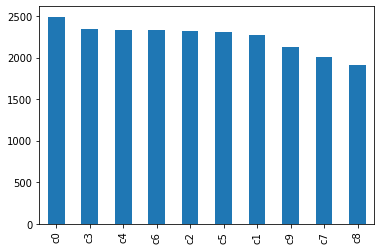

In [3]:
data.head()
class_count = data.classname.value_counts()
fig = class_count.plot(kind='bar')

**Working With ImageDataGenerator Class**

In [4]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    validation_split=0.2)

test_gen = ImageDataGenerator()

train_data= train_gen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    subset='validation'
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


**Making The Model**

Using EfficientNets to make our model

In [5]:
def define_model(num_classes):
    inputs = Input(shape=(224,224,3))
    base_model = EfficientNetB3(include_top=False, weights='imagenet')(inputs)
    x = GlobalAveragePooling2D()(base_model)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output = Dense(units=num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

model = define_model(10)
model.summary()

43941888/43941136 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                15370     
Total params: 10,805,049
Trainable params: 10,714,674
Non-trai

**Training Our Model**

In [6]:
checkpoint_callback = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es, checkpoint_callback])

Epoch 1/20
561/561 [==============================] - 544s 937ms/step - loss: 1.4381 - accuracy: 0.5545 - val_loss: 0.1640 - val_accuracy: 0.9496
Epoch 2/20
561/561 [==============================] - 432s 769ms/step - loss: 0.2245 - accuracy: 0.9287 - val_loss: 0.0938 - val_accuracy: 0.9719
Epoch 3/20
561/561 [==============================] - 445s 792ms/step - loss: 0.1242 - accuracy: 0.9619 - val_loss: 0.0869 - val_accuracy: 0.9766
Epoch 4/20
561/561 [==============================] - 433s 772ms/step - loss: 0.0871 - accuracy: 0.9735 - val_loss: 0.0569 - val_accuracy: 0.9799
Epoch 5/20
561/561 [==============================] - 435s 775ms/step - loss: 0.0689 - accuracy: 0.9770 - val_loss: 0.0484 - val_accuracy: 0.9850
Epoch 6/20
561/561 [==============================] - 435s 774ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.0367 - val_accuracy: 0.9895
Epoch 7/20
561/561 [==============================] - 436s 776ms/step - loss: 0.0520 - accuracy: 0.9841 - val_loss: 0.0336 -

**Evaluating Our Model**

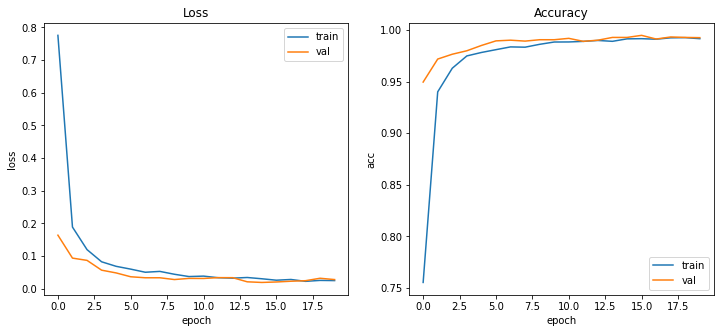

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'val'])

**Predictions**

In [8]:
test_dir = os.path.join(base_dir, 'imgs')

test_data = test_gen.flow_from_directory(
    test_dir,
    shuffle=False,
    target_size=IMAGE_SIZE,
    classes=['test'],
    batch_size=BATCH_SIZE
)

Found 79726 images belonging to 1 classes.


In [9]:
preds = model.predict(test_data)

In [10]:
test_imgs = os.path.join(base_dir, "imgs/test")

test_ids = sorted(os.listdir(test_imgs))
pred_df = pd.DataFrame(columns = ['img','c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
for i in range(len(preds)):
    pred_df.loc[i, 'img'] = test_ids[i]
    pred_df.loc[i, 'c0':'c9'] = preds[i]
    
pred_df.to_csv('submission.csv', index=False)

**Completed**